In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/privacy/")
from privacy.encode import encodeData, encodeNonAnonData
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/")

In [32]:
data = "occupancy"
method = "classic_mondrian"
k_list = [5, 20, 100, 500]

In [33]:
class Mondrian_Utility:
    def __init__(self, data, method, k_list):
        self.data = data
        self.method = method
        self.k_list = k_list
    
    def anonymize(self):
        for k in self.k_list:
            os.system(f'python privacy/anonymize.py --method={self.method} --k={k} --dataset={self.data}')
    
    def get_features(self):
        self.features = []
        self.val = []
        for k in self.k_list:
            pr_data, X_org, y_org, pr_data_anon, X_anon, y_anon = encodeData(self.data, self.method, k)
            if not len(self.features):
                self.features.append((X_org, y_org))
                pr_data.to_csv(f"./pr_mondrian_results/{self.data}_anonymized_org.csv", index=False)
            self.features.append((X_anon, y_anon))
            pr_data_anon.to_csv(f"./pr_mondrian_results/{self.data}_anonymized_{k}.csv", index=False)
        _, X_val, y_val = encodeNonAnonData(self.data, f'/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/{self.data}/val.csv')
        self.val_data = X_val, y_val

    def get_model(self):
        self.models = []
        for _ in range(len(self.features)):
            if self.data == "texas":
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(1)])
            elif self.data == "adult":
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])
            else:
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(10, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(4, activation='softmax')])
            self.models.append(model)

    def compile_models(self):
        for i in range(len(self.models)):
            if self.data == "adult":
                self.models[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                    loss='binary_crossentropy',
                    metrics=["accuracy"])
            elif self.data == "texas":
                self.models[i].compile(optimizer='adam',
                    loss='mean_squared_error')
            else:
                self.models[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                    loss='categorical_crossentropy',
                    metrics=["accuracy"])

    def prepare_training(self):
        self.anonymize()
        self.get_features()
        self.get_model()
        self.compile_models()
    
    def train(self):
        self.histories = []
        for i in range(len(self.k_list) + 1):
            X, y = self.features[i]
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
            history = self.models[i].fit(X, y, epochs=100, batch_size=64, validation_data=self.val_data, callbacks=[callback])
            self.histories.append(history)
            if i == 0:
                self.models[i].save(f"./weights/model_{self.data}_org.h5")
            else:
                self.models[i].save(f"./weights/model_{self.data}_{k_list[i-1]}.h5")
            print(f"{i+1} trained.")

    def plot_results(self):
        for i in range(len(self.histories)):
            if i == 0:
                plt.plot(self.histories[i].history['accuracy'], label="Original")
            else:
                plt.plot(self.histories[i].history['accuracy'], label=f"K = {self.k_list[i-1]}")
        plt.title("Train Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
            

In [34]:
mond_util = Mondrian_Utility(data, method, k_list)

In [35]:
mond_util.prepare_training()

Anonymize with classic_mondrian
NCP score (lower is better): 0.049
CAVG score (near 1 is better): BEFORE: 0.200 || AFTER: 1.441
DM score (lower is better): BEFORE: 60031504 || AFTER: 69334
Time execution: 0.164s
Anonymize with classic_mondrian
NCP score (lower is better): 0.096
CAVG score (near 1 is better): BEFORE: 0.050 || AFTER: 1.446
DM score (lower is better): BEFORE: 60031504 || AFTER: 239080
Time execution: 0.074s
Anonymize with classic_mondrian
NCP score (lower is better): 0.230
CAVG score (near 1 is better): BEFORE: 0.010 || AFTER: 1.435
DM score (lower is better): BEFORE: 60031504 || AFTER: 1200692
Time execution: 0.047s
Anonymize with classic_mondrian
NCP score (lower is better): 0.459
CAVG score (near 1 is better): BEFORE: 0.002 || AFTER: 1.550
DM score (lower is better): BEFORE: 60031504 || AFTER: 6194134
Time execution: 0.026s
Replacing all generalized values...


7748it [00:00, 24181.53it/s]


Replacing all generalized values...


7748it [00:00, 23664.31it/s]


Replacing all generalized values...


7748it [00:00, 24409.54it/s]


Replacing all generalized values...


7748it [00:00, 24540.26it/s]


Replacing all generalized values...


861it [00:00, 28706.64it/s]


In [36]:
mond_util.train()

Epoch 1/100


2023-11-27 15:35:23.219188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - ETA: 0s - loss: 1.9098 - accuracy: 0.2122

2023-11-27 15:35:27.289874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 5s 34ms/step - loss: 1.9098 - accuracy: 0.2122 - val_loss: 1.4578 - val_accuracy: 0.2184
Epoch 2/100
122/122 [==============================] - 2s 18ms/step - loss: 1.5540 - accuracy: 0.4577 - val_loss: 1.2591 - val_accuracy: 0.5041
Epoch 3/100
122/122 [==============================] - 2s 17ms/step - loss: 1.2433 - accuracy: 0.6680 - val_loss: 1.0934 - val_accuracy: 0.6702
Epoch 4/100
122/122 [==============================] - 2s 17ms/step - loss: 0.9977 - accuracy: 0.7747 - val_loss: 0.9705 - val_accuracy: 0.6841
Epoch 5/100
122/122 [==============================] - 2s 17ms/step - loss: 0.8078 - accuracy: 0.8052 - val_loss: 0.9084 - val_accuracy: 0.6945
Epoch 6/100
122/122 [==============================] - 2s 18ms/step - loss: 0.6700 - accuracy: 0.8271 - val_loss: 0.9009 - val_accuracy: 0.7003
Epoch 7/100
122/122 [==============================] - 2s 18ms/step - loss: 0.5677 - accuracy: 0.8428 - val_loss: 0.9212 - val_accuracy: 0.7003
Epoc

2023-11-27 15:35:49.147252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - ETA: 0s - loss: 1.7242 - accuracy: 0.2210

2023-11-27 15:35:51.396659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 3s 19ms/step - loss: 1.7242 - accuracy: 0.2210 - val_loss: 1.4203 - val_accuracy: 0.3717
Epoch 2/100
122/122 [==============================] - 2s 17ms/step - loss: 1.2150 - accuracy: 0.5323 - val_loss: 1.1439 - val_accuracy: 0.6527
Epoch 3/100
122/122 [==============================] - 2s 17ms/step - loss: 0.8966 - accuracy: 0.7011 - val_loss: 0.9839 - val_accuracy: 0.7050
Epoch 4/100
122/122 [==============================] - 2s 17ms/step - loss: 0.7088 - accuracy: 0.7463 - val_loss: 0.9068 - val_accuracy: 0.7236
Epoch 5/100
122/122 [==============================] - 2s 17ms/step - loss: 0.5921 - accuracy: 0.7686 - val_loss: 0.8791 - val_accuracy: 0.7433
Epoch 6/100
122/122 [==============================] - 2s 17ms/step - loss: 0.5193 - accuracy: 0.7877 - val_loss: 0.8756 - val_accuracy: 0.7573
Epoch 7/100
122/122 [==============================] - 2s 17ms/step - loss: 0.4663 - accuracy: 0.8034 - val_loss: 0.8871 - val_accuracy: 0.7689
Epoc

2023-11-27 15:36:12.645482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - ETA: 0s - loss: 1.3078 - accuracy: 0.4810

2023-11-27 15:36:15.180604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 3s 22ms/step - loss: 1.3078 - accuracy: 0.4810 - val_loss: 1.4780 - val_accuracy: 0.5656
Epoch 2/100
122/122 [==============================] - 2s 17ms/step - loss: 1.0291 - accuracy: 0.6658 - val_loss: 1.2798 - val_accuracy: 0.6132
Epoch 3/100
122/122 [==============================] - 2s 17ms/step - loss: 0.8075 - accuracy: 0.7669 - val_loss: 1.1445 - val_accuracy: 0.6376
Epoch 4/100
122/122 [==============================] - 2s 18ms/step - loss: 0.6576 - accuracy: 0.7961 - val_loss: 1.0665 - val_accuracy: 0.6481
Epoch 5/100
122/122 [==============================] - 2s 18ms/step - loss: 0.5554 - accuracy: 0.8130 - val_loss: 1.0379 - val_accuracy: 0.6609
Epoch 6/100
122/122 [==============================] - 2s 18ms/step - loss: 0.4866 - accuracy: 0.8234 - val_loss: 1.0377 - val_accuracy: 0.6760
Epoch 7/100
122/122 [==============================] - 2s 20ms/step - loss: 0.4405 - accuracy: 0.8314 - val_loss: 1.0530 - val_accuracy: 0.6794
Epoc

2023-11-27 15:36:37.422807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - ETA: 0s - loss: 1.8218 - accuracy: 0.2669

2023-11-27 15:36:39.713883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 3s 20ms/step - loss: 1.8218 - accuracy: 0.2669 - val_loss: 1.5355 - val_accuracy: 0.0894
Epoch 2/100
122/122 [==============================] - 2s 17ms/step - loss: 1.4097 - accuracy: 0.4330 - val_loss: 1.2819 - val_accuracy: 0.4588
Epoch 3/100
122/122 [==============================] - 2s 19ms/step - loss: 1.1080 - accuracy: 0.5851 - val_loss: 1.0988 - val_accuracy: 0.5865
Epoch 4/100
122/122 [==============================] - 2s 18ms/step - loss: 0.9218 - accuracy: 0.6606 - val_loss: 0.9804 - val_accuracy: 0.6806
Epoch 5/100
122/122 [==============================] - 2s 18ms/step - loss: 0.8006 - accuracy: 0.7048 - val_loss: 0.9124 - val_accuracy: 0.7317
Epoch 6/100
122/122 [==============================] - 2s 19ms/step - loss: 0.7057 - accuracy: 0.7506 - val_loss: 0.8809 - val_accuracy: 0.7422
Epoch 7/100
122/122 [==============================] - 2s 17ms/step - loss: 0.6431 - accuracy: 0.7790 - val_loss: 0.8710 - val_accuracy: 0.7677
Epoc

2023-11-27 15:37:03.888257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - ETA: 0s - loss: 1.1375 - accuracy: 0.6356

2023-11-27 15:37:06.355863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 3s 21ms/step - loss: 1.1375 - accuracy: 0.6356 - val_loss: 0.9363 - val_accuracy: 0.7805
Epoch 2/100
122/122 [==============================] - 2s 19ms/step - loss: 0.9223 - accuracy: 0.6962 - val_loss: 0.8436 - val_accuracy: 0.7886
Epoch 3/100
122/122 [==============================] - 2s 17ms/step - loss: 0.7859 - accuracy: 0.7568 - val_loss: 0.7941 - val_accuracy: 0.7875
Epoch 4/100
122/122 [==============================] - 2s 17ms/step - loss: 0.7031 - accuracy: 0.7792 - val_loss: 0.7734 - val_accuracy: 0.7991
Epoch 5/100
122/122 [==============================] - 2s 17ms/step - loss: 0.6492 - accuracy: 0.8025 - val_loss: 0.7683 - val_accuracy: 0.8142
Epoch 6/100
122/122 [==============================] - 2s 17ms/step - loss: 0.6178 - accuracy: 0.8220 - val_loss: 0.7726 - val_accuracy: 0.8177
Epoch 7/100
122/122 [==============================] - 2s 17ms/step - loss: 0.5924 - accuracy: 0.8201 - val_loss: 0.7828 - val_accuracy: 0.8177
Epoc

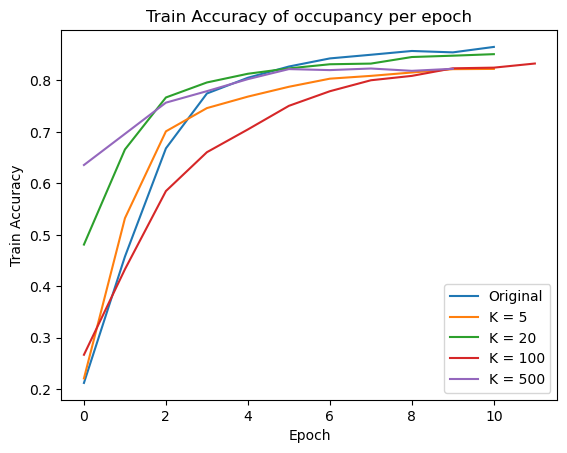

In [38]:
for i in range(len(mond_util.histories)):
    if i == 0:
        plt.plot(mond_util.histories[i].history['accuracy'], label="Original")
    else:
        plt.plot(mond_util.histories[i].history['accuracy'], label=f"K = {mond_util.k_list[i-1]}")
plt.xlabel("Epoch")
plt.ylabel(f"Train Accuracy")
plt.title(f"Train Accuracy of {data} per epoch")
plt.legend()
plt.show()

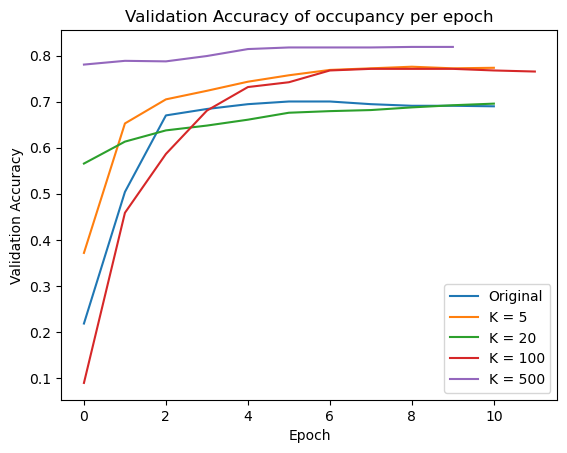

In [39]:
for i in range(len(mond_util.histories)):
    if i == 0:
        plt.plot(mond_util.histories[i].history['val_accuracy'], label="Original")
    else:
        plt.plot(mond_util.histories[i].history['val_accuracy'], label=f"K = {mond_util.k_list[i-1]}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title(f"Validation Accuracy of {data} per epoch")
plt.legend()
plt.show()

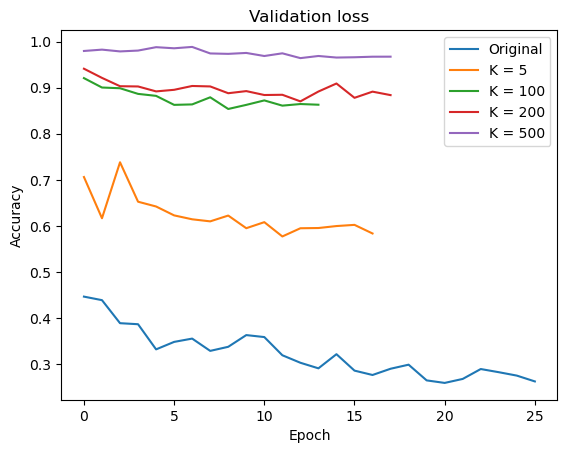

In [15]:
for i in range(len(mond_util.histories)):
    if i == 0:
        plt.plot(mond_util.histories[i].history['val_loss'], label="Original")
    else:
        plt.plot(mond_util.histories[i].history['val_loss'], label=f"K = {mond_util.k_list[i-1]}")
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
test_accs = {}
for i in range(len(mond_util.k_list) + 1):
    if i == 0:
        mond_util.models[i] = tf.keras.models.load_model(f"./weights/model_{data}_org.h5")
    else:
        mond_util.models[i] = tf.keras.models.load_model(f"./weights/model_{data}_{k_list[i-1]}.h5")
    X, y = mond_util.features[i]
    _, X_test, y_test = encodeNonAnonData(data, f"/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/{data}/test.csv")
    res = mond_util.models[i].evaluate(X_test, y_test)
    if i == 0:
        test_accs["Original"] = res
    else:
        test_accs[f"K = {k_list[i-1]}"] = res
print(test_accs)

Replacing all generalized values...


15060it [00:00, 24600.12it/s]
2023-11-27 15:13:35.885549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but

471/471 [==============================] - 4s 8ms/step - loss: 1.9537 - accuracy: 0.6376


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 24670.56it/s]
2023-11-27 15:13:40.969231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but

471/471 [==============================] - 4s 8ms/step - loss: 0.9303 - accuracy: 0.6284


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 25064.62it/s]
2023-11-27 15:13:46.054083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but

471/471 [==============================] - 4s 7ms/step - loss: 0.8599 - accuracy: 0.6208


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 24189.74it/s]
2023-11-27 15:13:51.007430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but

471/471 [==============================] - 4s 7ms/step - loss: 0.6988 - accuracy: 0.6118


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 24761.71it/s]
2023-11-27 15:13:56.020459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but

471/471 [==============================] - 4s 7ms/step - loss: 0.6565 - accuracy: 0.5924
{'Original': [1.9537066221237183, 0.6375830173492432], 'K = 5': [0.930282473564148, 0.6283532381057739], 'K = 20': [0.8598965406417847, 0.6207835078239441], 'K = 100': [0.6987952589988708, 0.611752986907959], 'K = 500': [0.6565106511116028, 0.5923638939857483]}


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


In [103]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

In [7]:
ori = pd.read_csv("./pr_mondrian_results/occupancy_anonymized_org.csv")
control, _, _ = encodeNonAnonData("occupancy", "/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/occupancy/test.csv")

NameError: name 'pd' is not defined

In [90]:
risks = {}
for k in k_list:
    syn = pd.read_csv(f"./pr_mondrian_results/occupancy_anonymized_{k}.csv")
    evaluator = SinglingOutEvaluator(ori=ori, 
                                    syn=syn, 
                                    control=control,
                                    n_attacks=100, # this attack takes longer
                                    n_cols=4)


    try:
        evaluator.evaluate(mode='multivariate')
        risk = evaluator.risk()
        print(risk.value)
        risks[f"K = {k}"] = risk.value

    except RuntimeError as ex: 
        print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
            "For more stable results increase `n_attacks`. Note that this will "
            "make the evaluation slower.")

0.10918250215256743
0.01740622151333518


/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.028126814121422983, baseline = 0.028126814121422983. Analysis results cannot be trusted.
  self._sanity_check()


0.001844311770318952
0.08059817983799487


/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.04738694415728327, baseline = 0.057017009175213414. Analysis results cannot be trusted.
  self._sanity_check()


0.016244766584956986
0.0415280965743401
0.04102028043938658


In [ ]:
test = sorted(test_accs.items(), key=lambda kv: (kv[1], kv[0]))
test_accs = {}
for t in test:
    test_accs[t[0]] = t[1]

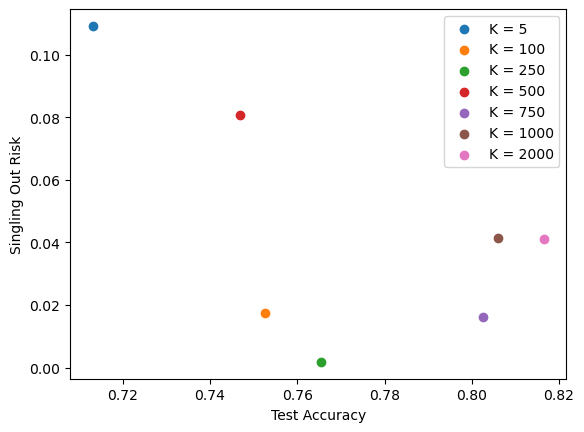

In [92]:
for k in k_list:
    plt.scatter(test_accs[f"K = {k}"], risks[f"K = {k}"], label=f"K = {k}")
plt.ylabel("Singling Out Risk")
plt.xlabel("Test Accuracy")
plt.legend()
plt.show()

In [9]:
test_accs

{}

<BarContainer object of 3 artists>

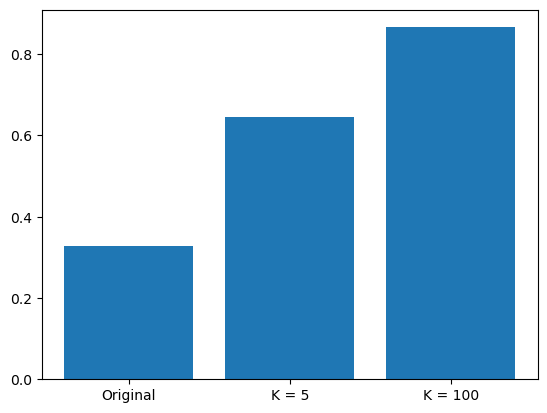

In [11]:
names = ["Original"] + [f"K = {k}" for k in k_list]
height = [test_accs[name] for name in names]
plt.bar(names, height)

In [111]:
from sklearn.metrics import f1_score
import numpy as np
f1s = {}
for i in range(len(mond_util.k_list) + 1):
    if i == 0:
        mond_util.models[i] = tf.keras.models.load_model("./weights/model_org.h5")
    else:
        mond_util.models[i] = tf.keras.models.load_model(f"./weights/model_{k_list[i-1]}.h5")
    X, y = mond_util.features[i]
    _, X_test, y_test = encodeNonAnonData("occupancy", "/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/occupancy/test.csv")
    pred = mond_util.models[i].predict(X_test)
    f1 = f1_score(y_test, pred>0.5, average='weighted')
    print(f1)
    if i == 0:
        f1s["Original"] = f1
    else:
        f1s[f"K = {k_list[i-1]}"] = f1
# print(f1s)

Replacing all generalized values...


861it [00:00, 28388.46it/s]

27/27 [==============================] - 0s 3ms/step
0.6817690143297375



2023-11-26 23:44:30.772430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Replacing all generalized values...


861it [00:00, 28405.43it/s]

27/27 [==============================] - 0s 3ms/step
0.67082258735795



2023-11-26 23:44:31.025067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Replacing all generalized values...


861it [00:00, 28371.73it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:31.295302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7012329333814965
Replacing all generalized values...


861it [00:00, 27209.06it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:31.577586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6588048663843884
Replacing all generalized values...


861it [00:00, 28359.70it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:31.844527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.683367511010111
Replacing all generalized values...


861it [00:00, 28395.38it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:32.105572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6657236902228004
Replacing all generalized values...


861it [00:00, 28650.39it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:32.378703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6836894232364615
Replacing all generalized values...


861it [00:00, 27425.62it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:32.635863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7215795586527294
Replacing all generalized values...


861it [00:00, 28442.12it/s]

27/27 [==============================] - 0s 3ms/step
0.7264940774116908



2023-11-26 23:44:32.892648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<BarContainer object of 9 artists>

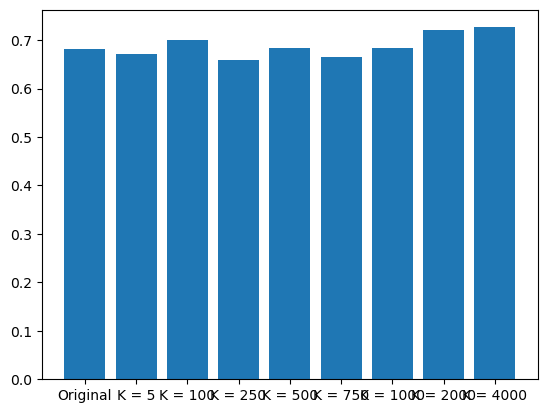

In [112]:
names = ["Original"] + [f"K = {k}" for k in k_list]
height = [f1s[name] for name in names]
plt.bar(names, height)

In [ ]:
# Make it work for adult
# See syn for occ